# Scraping Safety Data - City of Toronto Police

Because this is GEOJSON data, I could not use Beautifulsoup4. So, the processes below is really to import and convert to a pandas dataframe. Then, I can explore these data.

In [2]:
import osmnx  # to import and manage road netwrok data
import geopandas  # needed get background data
import requests  # for making standard html requests
import pandas  # premier library for data organization
import numpy  # for data manipulation
import rasterstats # to interpolate raster data
from random import shuffle # for managing psedoabsences

URL_Robbery = 'https://opendata.arcgis.com/datasets/9115accc55f24938b4eb573dd222c33b_0.geojson'
URL_Pedestrian = 'https://opendata.arcgis.com/datasets/1e8a71c533fb4b0aa522cf1b1236bee7_0.geojson'
page_robbery = requests.get(URL_Robbery).json()
page_pedestrian = requests.get(URL_Pedestrian).json()

pedestrian_json_df = pandas.json_normalize(page_pedestrian['features'])
robbery_json_df = pandas.json_normalize(page_robbery['features'])  

Interested in the number of features and which columns I should keep.

In [4]:
list(pedestrian_json_df)

['type',
 'properties.Index_',
 'properties.ACCNUM',
 'properties.YEAR',
 'properties.DATE',
 'properties.TIME',
 'properties.HOUR',
 'properties.STREET1',
 'properties.STREET2',
 'properties.OFFSET',
 'properties.ROAD_CLASS',
 'properties.District',
 'properties.WardNum',
 'properties.Division',
 'properties.LATITUDE',
 'properties.LONGITUDE',
 'properties.LOCCOORD',
 'properties.ACCLOC',
 'properties.TRAFFCTL',
 'properties.VISIBILITY',
 'properties.LIGHT',
 'properties.RDSFCOND',
 'properties.ACCLASS',
 'properties.IMPACTYPE',
 'properties.INVTYPE',
 'properties.INVAGE',
 'properties.INJURY',
 'properties.FATAL_NO',
 'properties.INITDIR',
 'properties.VEHTYPE',
 'properties.MANOEUVER',
 'properties.DRIVACT',
 'properties.DRIVCOND',
 'properties.PEDTYPE',
 'properties.PEDACT',
 'properties.PEDCOND',
 'properties.CYCLISTYPE',
 'properties.CYCACT',
 'properties.CYCCOND',
 'properties.PEDESTRIAN',
 'properties.CYCLIST',
 'properties.AUTOMOBILE',
 'properties.MOTORCYCLE',
 'properties.TR

In [5]:
len(pedestrian_json_df)

6484

In [6]:
list(robbery_json_df)

['type',
 'properties.Index_',
 'properties.event_unique_id',
 'properties.occurrencedate',
 'properties.reporteddate',
 'properties.premisetype',
 'properties.ucr_code',
 'properties.ucr_ext',
 'properties.offence',
 'properties.reportedyear',
 'properties.reportedmonth',
 'properties.reportedday',
 'properties.reporteddayofyear',
 'properties.reporteddayofweek',
 'properties.reportedhour',
 'properties.occurrenceyear',
 'properties.occurrencemonth',
 'properties.occurrenceday',
 'properties.occurrencedayofyear',
 'properties.occurrencedayofweek',
 'properties.occurrencehour',
 'properties.MCI',
 'properties.Division',
 'properties.Hood_ID',
 'properties.Neighbourhood',
 'properties.Long',
 'properties.Lat',
 'properties.ObjectId',
 'geometry.type',
 'geometry.coordinates']

In [7]:
len(robbery_json_df)

21543

Strange, but each column has a properties. prefix. Looks weird, so I am going to remove it

In [8]:
pedestrian_json_df.columns = pedestrian_json_df.columns.str.lstrip('properties.')
robbery_json_df.columns = robbery_json_df.columns.str.lstrip('properties.')

Focusing on features that I believe are predictive.

In [9]:
pedestrian_json_df

,ype,Index_,ACCNUM,YEAR,DATE,TIME,HOUR,STREET1,STREET2,OFFSET,...,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,Hood_ID,Neighbourhood,ObjectId,geometry.type,geometry.coordinates
0,Feature,3366651,884090,2006,2006/01/02 05:00:00+00,705,7,BATHURST ST,DUNDAS ST W,60 NORTH OF,...,None,None,None,None,None,78,Kensington-Chinatown (78),1,Point,"[-79.406253, 43.652892]"
1,Feature,3366652,884090,2006,2006/01/02 05:00:00+00,705,7,BATHURST ST,DUNDAS ST W,60 NORTH OF,...,None,None,None,None,None,78,Kensington-Chinatown (78),2,Point,"[-79.406253, 43.652892]"
2,Feature,3370333,885782,2006,2006/01/04 05:00:00+00,1940,19,DUFFERIN ST,SYLVAN AVE,None,...,None,None,None,None,None,83,Dufferin Grove (83),3,Point,"[-79.43359, 43.655145]"
3,Feature,3370334,885782,2006,2006/01/04 05:00:00+00,1940,19,DUFFERIN ST,SYLVAN AVE,None,...,None,None,None,None,None,83,Dufferin Grove (83),4,Point,"[-79.43359, 43.655145]"
4,Feature,3363337,882079,2006,2006/01/06 05:00:00+00,2210,22,DON MILLS RD,LEITH HILL RD,None,...,None,None,None,None,None,47,Don Valley Village (47),5,Point,"[-79.347858, 43.777056]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6479,Feature,81278209,9001182119,2019,2019/06/25 04:00:00+00,2002,20,MIDLAND AVENUE,MIDWEST ROAD,None,...,None,None,None,None,None,127,Bendale (127),6480,Point,"[-79.270527, 43.765876]"
6480,Feature,81278210,9001182119,2019,2019/06/25 04:00:00+00,2002,20,MIDLAND AVENUE,MIDWEST ROAD,None,...,None,None,None,None,None,127,Bendale (127),6481,Point,"[-79.270527, 43.765876]"
6481,Feature,81270264,9001184914,2019,2019/06/26 04:00:00+00,902,9,VICTORIA ST,QUEEN ST E,None,...,None,None,None,None,None,75,Church-Yonge Corridor (75),6482,Point,"[-79.378055, 43.65261]"
6482,Feature,81270268,9001184914,2019,2019/06/26 04:00:00+00,902,9,VICTORIA ST,QUEEN ST E,None,...,None,None,None,None,None,75,Church-Yonge Corridor (75),6483,Point,"[-79.378055, 43.65261]"


In [10]:
robbery_json_df

,ype,Index_,vent_unique_id,ccurrencedate,ddate,misetype,ucr_code,ucr_ext,ffence,dyear,...,ccurrencehour,MCI,Division,Hood_ID,Neighbourhood,Long,Lat,ObjectId,geometry.type,geometry.coordinates
0,Feature,1,GO-20141289469,1388970480000,1388973420000,Other,1610,200,Robbery - Mugging,2014,...,1,Robbery,D31,27,York University Heights (27),-79.503388,43.769791,1,Point,"[-79.5033875, 43.7697906]"
1,Feature,609,GO-20142439653,1404609480000,1404609480000,Outside,1610,160,Robbery - Taxi,2014,...,1,Robbery,D51,75,Church-Yonge Corridor (75),-79.371910,43.650467,2,Point,"[-79.3719101, 43.6504669]"
2,Feature,4,GO-20141331950,1389560280000,1389560280000,Other,1610,100,Robbery With Weapon,2014,...,20,Robbery,D42,130,Milliken (130),-79.300468,43.808918,3,Point,"[-79.3004684, 43.808918]"
3,Feature,610,GO-20142440272,1404617400000,1404618120000,Outside,1610,200,Robbery - Mugging,2014,...,3,Robbery,D43,139,Scarborough Village (139),-79.217850,43.740662,4,Point,"[-79.2178497, 43.7406616]"
4,Feature,5,GO-20141331950,1389560280000,1389560280000,Other,1610,100,Robbery With Weapon,2014,...,20,Robbery,D42,130,Milliken (130),-79.300468,43.808918,5,Point,"[-79.3004684, 43.808918]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21538,Feature,194136,GO-20182197844,1543522800000,1543522920000,Outside,1610,220,Robbery - Other,2018,...,20,Robbery,D23,5,Elms-Old Rexdale (5),-79.551002,43.723167,21539,Point,"[-79.5510025, 43.7231674]"
21539,Feature,194141,GO-20182269351,1544491200000,1544491260000,Apartment,1610,130,Robbery - Home Invasion,2018,...,1,Robbery,D51,72,Regent Park (72),-79.358688,43.662418,21540,Point,"[-79.3586884, 43.6624184]"
21540,Feature,194142,GO-20182269351,1544491200000,1544491260000,Apartment,1610,130,Robbery - Home Invasion,2018,...,1,Robbery,D51,72,Regent Park (72),-79.358688,43.662418,21541,Point,"[-79.3586884, 43.6624184]"
21541,Feature,194143,GO-20182269351,1544491200000,1544491260000,Apartment,1610,130,Robbery - Home Invasion,2018,...,1,Robbery,D51,72,Regent Park (72),-79.358688,43.662418,21542,Point,"[-79.3586884, 43.6624184]"


In [11]:
pedestrian_df = pedestrian_json_df.iloc[:, numpy.r_[3,5,6, 10, 14,15, 19, 20]]
pedestrian_df

,YEAR,TIME,HOUR,ROAD_CLASS,LATITUDE,LONGITUDE,VISIBILITY,LIGHT
0,2006,705,7,Major Arterial,43.652892,-79.406253,Other,"Dark, artificial"
1,2006,705,7,Major Arterial,43.652892,-79.406253,Other,"Dark, artificial"
2,2006,1940,19,Major Arterial,43.655145,-79.433590,Rain,Dark
3,2006,1940,19,Major Arterial,43.655145,-79.433590,Rain,Dark
4,2006,2210,22,Major Arterial,43.777056,-79.347858,Clear,"Dark, artificial"
...,...,...,...,...,...,...,...,...
6479,2019,2002,20,Major Arterial,43.765876,-79.270527,Clear,Daylight
6480,2019,2002,20,Major Arterial,43.765876,-79.270527,Clear,Daylight
6481,2019,902,9,Major Arterial,43.652610,-79.378055,Clear,Daylight
6482,2019,902,9,Major Arterial,43.652610,-79.378055,Clear,Daylight


In [12]:
robbery_df = robbery_json_df.iloc[:, numpy.r_[1:3, 9, 10, 11, 12, 13, 14, 5, 8, 22, 23, 25, 26]]
robbery_df

,Index_,vent_unique_id,dyear,dmonth,dday,ddayofyear,ddayofweek,dhour,misetype,ffence,Division,Hood_ID,Long,Lat
0,1,GO-20141289469,2014,January,6,6,Monday,1,Other,Robbery - Mugging,D31,27,-79.503388,43.769791
1,609,GO-20142439653,2014,July,6,187,Sunday,1,Outside,Robbery - Taxi,D51,75,-79.371910,43.650467
2,4,GO-20141331950,2014,January,12,12,Sunday,20,Other,Robbery With Weapon,D42,130,-79.300468,43.808918
3,610,GO-20142440272,2014,July,6,187,Sunday,3,Outside,Robbery - Mugging,D43,139,-79.217850,43.740662
4,5,GO-20141331950,2014,January,12,12,Sunday,20,Other,Robbery With Weapon,D42,130,-79.300468,43.808918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21538,194136,GO-20182197844,2018,November,29,333,Thursday,20,Outside,Robbery - Other,D23,5,-79.551002,43.723167
21539,194141,GO-20182269351,2018,December,11,345,Tuesday,1,Apartment,Robbery - Home Invasion,D51,72,-79.358688,43.662418
21540,194142,GO-20182269351,2018,December,11,345,Tuesday,1,Apartment,Robbery - Home Invasion,D51,72,-79.358688,43.662418
21541,194143,GO-20182269351,2018,December,11,345,Tuesday,1,Apartment,Robbery - Home Invasion,D51,72,-79.358688,43.662418


I will subset the data. For the robbery data, I only want the mugging data because this is most applicable for pedestrians

In [13]:
robbery_df_mugging = robbery_df.loc[robbery_df['ffence'] == 'Robbery - Mugging']  # 6847 rows
robbery_df_mugging_outside = robbery_df_mugging.loc[robbery_df_mugging['misetype'] == 'Outside']  # 5141 rows
robbery_df_mugging_outside

,Index_,vent_unique_id,dyear,dmonth,dday,ddayofyear,ddayofweek,dhour,misetype,ffence,Division,Hood_ID,Long,Lat
3,610,GO-20142440272,2014,July,6,187,Sunday,3,Outside,Robbery - Mugging,D43,139,-79.217850,43.740662
5,614,GO-20142444068,2014,July,6,187,Sunday,19,Outside,Robbery - Mugging,D22,18,-79.504143,43.601009
6,9,GO-20141332202,2014,January,12,12,Sunday,22,Outside,Robbery - Mugging,D51,76,-79.382118,43.659100
7,639,GO-20142117825,2014,May,20,140,Tuesday,19,Outside,Robbery - Mugging,D54,58,-79.348290,43.696964
9,640,GO-20142117825,2014,May,20,140,Tuesday,19,Outside,Robbery - Mugging,D54,58,-79.348290,43.696964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21494,193808,GO-20192121296,2019,November,2,306,Saturday,23,Outside,Robbery - Mugging,D33,42,-79.339500,43.728607
21498,193848,GO-20181659688,2018,September,7,250,Friday,17,Outside,Robbery - Mugging,D31,25,-79.510452,43.749229
21503,193886,GO-20182208408,2018,December,1,335,Saturday,12,Outside,Robbery - Mugging,D42,116,-79.322540,43.816147
21516,194015,GO-20181990705,2018,October,28,301,Sunday,17,Outside,Robbery - Mugging,D43,137,-79.233078,43.758186


Some features are unbalanced. I will remove accident locations with few observations (<10)


In [14]:
pedestrian_df_road = pedestrian_df.loc[pedestrian_df['ROAD_CLASS'].isin(['Major Arterial', 'Minor Arterial',
                                                                         'Collector', 'Local',
                                                                         'Expressway'])]  # 4986 rows

I will need to create geaodataframes many times, so a function will be best to make the code cleaner.

In [15]:
def create_gdf(df, Longitude, Latitude, projection):
    return geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df[Longitude], df[Latitude]),
                                  crs=projection)

Need as spatial data to measure distance to features later.

In [16]:
robbery_points_gdf_2958 = create_gdf(df=robbery_df_mugging_outside,
                                     Latitude="Lat",
                                     Longitude="Long",
                                     projection="EPSG:4326")

robbery_points_gdf_4326 = create_gdf(df=robbery_df_mugging_outside,
                                     Latitude="Lat",
                                     Longitude="Long",
                                     projection="EPSG:4326")
robbery_points_gdf_2958 = robbery_points_gdf_2958.to_crs(epsg = 2958) 
pedestrian_points_gdf_2958 = create_gdf(df=pedestrian_df_road,
                                     Latitude="LATITUDE",
                                     Longitude="LONGITUDE",
                                     projection="EPSG:4326")

pedestrian_points_gdf_4326 = create_gdf(df=pedestrian_df_road,
                                        Latitude="LATITUDE",
                                        Longitude="LONGITUDE",
                                     projection="EPSG:4326")
pedestrian_points_gdf_2958 = pedestrian_points_gdf_2958.to_crs(epsg = 2958)  

Need consistency in labelling for future analyses

In [17]:
robbery_points_gdf_2958 = robbery_points_gdf_2958.rename(columns={"Long": "Longitude", "Lat": "Latitude"})
robbery_points_gdf_4326 = robbery_points_gdf_4326.rename(columns={"Long": "Longitude", "Lat": "Latitude"})
pedestrian_points_gdf_2958 = pedestrian_points_gdf_2958.rename(columns={"LONGITUDE": "Longitude", "LATITUDE": "Latitude"})
pedestrian_points_gdf_4326 = pedestrian_points_gdf_4326.rename(columns={"LONGITUDE": "Longitude", "LATITUDE": "Latitude"})

It will be easier to re-run making the psedoabsences if I make a function considering that I might extend to the GTA and not just Old Toronto.

In [18]:
def get_pseudoabsence_data(lat_min, lat_max, lon_min, lon_max, number_of_points):
    numpy.random.seed(13)
    pseudoabsence_latitudes = numpy.random.uniform(lat_min, lat_max, number_of_points)
    pseudoabsence_longitudes = numpy.random.uniform(lon_min, lon_max, number_of_points)
    pseudoabsences = pandas.DataFrame(numpy.transpose(numpy.array([pseudoabsence_longitudes, pseudoabsence_latitudes])),
                                      columns=['Longitude', 'Latitude'])
    return (pseudoabsences)

Some of the background points will fall in the lake, so multipling by 4 to make sure I have enough falling on land. Then, I will convert to a spaital layer for later measuring distance to feature, which I will include in my predictive model.

In [19]:
robbery_backgroundpoints = get_pseudoabsence_data(lat_min=robbery_points_gdf_4326['Latitude'].min(),
                                                  lat_max=robbery_points_gdf_4326['Latitude'].max(),
                                                  lon_min=robbery_points_gdf_4326['Longitude'].min(),
                                                  lon_max=robbery_points_gdf_4326['Longitude'].max(),
                                                  number_of_points=len(robbery_points_gdf_4326) * 4)

robbery_backgroundpoints_gdf_2958 = create_gdf(df=robbery_backgroundpoints,
                                               Latitude="Latitude",
                                               Longitude="Longitude",
                                               projection="EPSG:4326")
robbery_backgroundpoints_gdf_4326 = create_gdf(df=robbery_backgroundpoints,
                                               Latitude="Latitude",
                                               Longitude="Longitude",
                                               projection="EPSG:4326")

robbery_backgroundpoints_gdf_2958 = robbery_backgroundpoints_gdf_2958.to_crs(epsg = 2958) 

pedestrian_backgroundpoints = get_pseudoabsence_data(lat_min=pedestrian_points_gdf_4326['Latitude'].min(),
                                                  lat_max=pedestrian_points_gdf_4326['Latitude'].max(),
                                                  lon_min=pedestrian_points_gdf_4326['Longitude'].min(),
                                                  lon_max=pedestrian_points_gdf_4326['Longitude'].max(),
                                                  number_of_points=len(pedestrian_points_gdf_4326) * 4)

pedestrian_backgroundpoints_gdf_2958 = create_gdf(df=pedestrian_backgroundpoints,
                                               Latitude="Latitude",
                                               Longitude="Longitude",
                                               projection="EPSG:4326")
pedestrian_backgroundpoints_gdf_4326 = create_gdf(df=pedestrian_backgroundpoints,
                                               Latitude="Latitude",
                                               Longitude="Longitude",
                                               projection="EPSG:4326")

pedestrian_backgroundpoints_gdf_2958 = pedestrian_backgroundpoints_gdf_2958.to_crs(epsg = 2958) 

Importing location Data to Measure Proximity transporation data to later measure distance to feature for regression/random forest need a UTM projection for distance to feature.


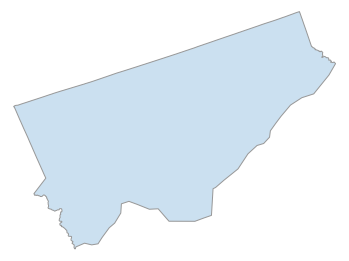

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a7ad528648>)

In [21]:
place_name = 'City of Toronto'
place_shape = osmnx.gdf_from_place(place_name)
osmnx.plot_shape(osmnx.projection.project_gdf(place_shape))

In [22]:
selected_tags = {'highway': True}
stations_OldToronto = osmnx.pois_from_place(place = place_name, tags = selected_tags)

Dropping some fetaures that I do not need some of them are polygons.

In [23]:
features_location_names = ['crossing', 'give_way', 'stop', 'traffic_signals', 'turning_loop', 'speed_camera']
stations_OldToronto_4326 = stations_OldToronto[stations_OldToronto.highway.isin(features_location_names)]
stations_OldToronto_4326 = stations_OldToronto_4326.iloc[:, numpy.r_[0, 1, 4]]

In [24]:
stations_OldToronto_4326

,osmid,geometry,highway
1497993,1497993,POINT (-79.34694 43.75577),traffic_signals
1497996,1497996,POINT (-79.34700 43.75864),traffic_signals
1498001,1498001,POINT (-79.34711 43.76181),traffic_signals
1498018,1498018,POINT (-79.34642 43.76957),traffic_signals
1498033,1498033,POINT (-79.34698 43.77518),traffic_signals
...,...,...,...
7620725135,7620725135,POINT (-79.30694 43.73462),stop
7624297885,7624297885,POINT (-79.40099 43.71833),stop
7624298019,7624298019,POINT (-79.40075 43.71879),stop
7626829863,7626829863,POINT (-79.38793 43.69139),stop


Converting to other projections gives me errors, so the gemteory tab is in ESPG 2958, but it read in as ESPG 4326 I will need to covert this to a etract the x y data convert to a dataframe, then reproject.

In [25]:
stations_OldToronto_4326['x'] = stations_OldToronto_4326['geometry'].x
stations_OldToronto_4326['y'] = stations_OldToronto_4326['geometry'].y
stations_OldToronto_4326 = pandas.DataFrame(stations_OldToronto_4326)

In [26]:
stations_OldToronto_4326

,osmid,geometry,highway,x,y
1497993,1497993,POINT (-79.34694 43.75577),traffic_signals,-79.346939,43.755775
1497996,1497996,POINT (-79.34700 43.75864),traffic_signals,-79.347003,43.758640
1498001,1498001,POINT (-79.34711 43.76181),traffic_signals,-79.347105,43.761808
1498018,1498018,POINT (-79.34642 43.76957),traffic_signals,-79.346419,43.769574
1498033,1498033,POINT (-79.34698 43.77518),traffic_signals,-79.346985,43.775183
...,...,...,...,...,...
7620725135,7620725135,POINT (-79.30694 43.73462),stop,-79.306942,43.734623
7624297885,7624297885,POINT (-79.40099 43.71833),stop,-79.400988,43.718328
7624298019,7624298019,POINT (-79.40075 43.71879),stop,-79.400746,43.718791
7626829863,7626829863,POINT (-79.38793 43.69139),stop,-79.387932,43.691393


Converting the node data to a geopanda dataframe so that I can extract elevation data.

In [27]:
stations_OldToronto_4326 = create_gdf(df=stations_OldToronto_4326,
                                      Latitude="y",
                                      Longitude="x",
                                      projection="EPSG:4326")
stations_OldToronto_2958 = create_gdf(df=stations_OldToronto_4326,
                                      Latitude="y",
                                      Longitude="x",
                                      projection="EPSG:4326")
stations_OldToronto_2958 = stations_OldToronto_4326.to_crs(epsg=2958) 

stations_OldToronto_2958 = stations_OldToronto_2958.iloc[:, numpy.r_[0, 1, 2]]
stations_OldToronto_2958['x'] = stations_OldToronto_2958['geometry'].x
stations_OldToronto_2958['y'] = stations_OldToronto_2958['geometry'].y

In [28]:
stations_OldToronto_2958

,osmid,geometry,highway,x,y
1497993,1497993,POINT (633075.953 4846075.713),traffic_signals,633075.953252,4.846076e+06
1497996,1497996,POINT (633064.482 4846393.824),traffic_signals,633064.482161,4.846394e+06
1498001,1498001,POINT (633049.209 4846745.480),traffic_signals,633049.209142,4.846745e+06
1498018,1498018,POINT (633087.220 4847609.194),traffic_signals,633087.220093,4.847609e+06
1498033,1498033,POINT (633029.254 4848231.184),traffic_signals,633029.253878,4.848231e+06
...,...,...,...,...,...
7620725135,7620725135,POINT (636343.869 4843791.509),stop,636343.869434,4.843792e+06
7624297885,7624297885,POINT (628805.083 4841831.208),stop,628805.083441,4.841831e+06
7624298019,7624298019,POINT (628823.600 4841883.085),stop,628823.599856,4.841883e+06
7626829863,7626829863,POINT (629914.950 4838860.114),stop,629914.949546,4.838860e+06


I am only interested in a few proximity features for my application, and the function to measure distance needs the projection in espg 4362 + the x and y coordinates named as x y.

In [29]:
stations_OldToronto_4326

,osmid,geometry,highway,x,y
1497993,1497993,POINT (-79.34694 43.75577),traffic_signals,-79.346939,43.755775
1497996,1497996,POINT (-79.34700 43.75864),traffic_signals,-79.347003,43.758640
1498001,1498001,POINT (-79.34711 43.76181),traffic_signals,-79.347105,43.761808
1498018,1498018,POINT (-79.34642 43.76957),traffic_signals,-79.346419,43.769574
1498033,1498033,POINT (-79.34698 43.77518),traffic_signals,-79.346985,43.775183
...,...,...,...,...,...
7620725135,7620725135,POINT (-79.30694 43.73462),stop,-79.306942,43.734623
7624297885,7624297885,POINT (-79.40099 43.71833),stop,-79.400988,43.718328
7624298019,7624298019,POINT (-79.40075 43.71879),stop,-79.400746,43.718791
7626829863,7626829863,POINT (-79.38793 43.69139),stop,-79.387932,43.691393


In [30]:
stations_OldToronto_md = stations_OldToronto_4326

# Generating proximity features for logistic regression/random forest

I was not able to find a function in python that allows me to easily measure proximity features, so I am going to use a function I found online. 

In [31]:
from sklearn.neighbors import BallTree
def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='haversine')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)


def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.

    NOTICE: Assumes that the input Points are in WGS84 projection (lat/lon).
    """

    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name

    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)

    # Parse coordinates from points and insert them into a numpy array as RADIANS
    left_radians = numpy.array(
        left_gdf[left_geom_col].apply(lambda geom: (geom.x * numpy.pi / 180, geom.y * numpy.pi / 180)).to_list())
    right_radians = numpy.array(
        right[right_geom_col].apply(lambda geom: (geom.x * numpy.pi / 180, geom.y * numpy.pi / 180)).to_list())

    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)

    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)

    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]

    # Ensure that the index corresponds the one in left_gdf
    closest_points = closest_points.reset_index(drop=True)

    # Add distance if requested
    if return_dist:
        # Convert to meters from radians
        earth_radius = 6371000  # meters
        closest_points['distance'] = dist * earth_radius

    return closest_points

Find closest public transport stop for each building and get also the distance based on haversine distance.**Note**:haversine distance, which is implemented here is a bit slower than using e.g. 'euclidean' metric but useful as we get the distance between points in meters.

In [32]:
for i in features_location_names:
    robbery_backgroundpoints_gdf_4326[i] = nearest_neighbor(robbery_backgroundpoints_gdf_4326,
                                                            stations_OldToronto_md.loc[
                                                                stations_OldToronto_md['highway'] == i],
                                                            return_dist=True)['distance']
    robbery_points_gdf_4326[i] = nearest_neighbor(robbery_points_gdf_4326,
                                                  stations_OldToronto_md.loc[
                                                      stations_OldToronto_md['highway'] == i],
                                                  return_dist=True)['distance']

for i in features_location_names:
    pedestrian_backgroundpoints_gdf_4326[i] = nearest_neighbor(pedestrian_backgroundpoints_gdf_4326,
                                                            stations_OldToronto_md.loc[
                                                                stations_OldToronto_md['highway'] == i],
                                                            return_dist=True)['distance']
    pedestrian_points_gdf_4326[i] = nearest_neighbor(pedestrian_points_gdf_4326,
                                                  stations_OldToronto_md.loc[
                                                      stations_OldToronto_md['highway'] == i],
                                                  return_dist=True)['distance']

In [35]:
robbery_points_gdf_4326

,Index_,vent_unique_id,dyear,dmonth,dday,ddayofyear,ddayofweek,dhour,misetype,ffence,...,Longitude,Latitude,geometry,crossing,give_way,stop,traffic_signals,turning_loop,speed_camera,Presence_Absence
3,610,GO-20142440272,2014,July,6,187,Sunday,3,Outside,Robbery - Mugging,...,-79.217850,43.740662,POINT (-79.21785 43.74066),81.995697,48.473164,2.386628,68.917585,3236.383024,13331.090431,1
5,614,GO-20142444068,2014,July,6,187,Sunday,19,Outside,Robbery - Mugging,...,-79.504143,43.601009,POINT (-79.50414 43.60101),2.039386,274.951034,59.537870,0.316241,593.217781,24848.639247,1
6,9,GO-20141332202,2014,January,12,12,Sunday,22,Outside,Robbery - Mugging,...,-79.382118,43.659100,POINT (-79.38212 43.65910),81.995697,48.473164,2.386628,68.917585,3236.383024,13331.090431,1
7,639,GO-20142117825,2014,May,20,140,Tuesday,19,Outside,Robbery - Mugging,...,-79.348290,43.696964,POINT (-79.34829 43.69696),76.450858,216.640462,10.563384,80.851437,498.830923,10331.498162,1
9,640,GO-20142117825,2014,May,20,140,Tuesday,19,Outside,Robbery - Mugging,...,-79.348290,43.696964,POINT (-79.34829 43.69696),105.218903,765.292495,136.286932,147.829411,733.706592,3755.859429,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21494,193808,GO-20192121296,2019,November,2,306,Saturday,23,Outside,Robbery - Mugging,...,-79.339500,43.728607,POINT (-79.33950 43.72861),NaN,NaN,NaN,NaN,NaN,NaN,1
21498,193848,GO-20181659688,2018,September,7,250,Friday,17,Outside,Robbery - Mugging,...,-79.510452,43.749229,POINT (-79.51045 43.74923),NaN,NaN,NaN,NaN,NaN,NaN,1
21503,193886,GO-20182208408,2018,December,1,335,Saturday,12,Outside,Robbery - Mugging,...,-79.322540,43.816147,POINT (-79.32254 43.81615),NaN,NaN,NaN,NaN,NaN,NaN,1
21516,194015,GO-20181990705,2018,October,28,301,Sunday,17,Outside,Robbery - Mugging,...,-79.233078,43.758186,POINT (-79.23308 43.75819),NaN,NaN,NaN,NaN,NaN,NaN,1


In [36]:
list(robbery_points_gdf_4326)

['Index_',
 'vent_unique_id',
 'dyear',
 'dmonth',
 'dday',
 'ddayofyear',
 'ddayofweek',
 'dhour',
 'misetype',
 'ffence',
 'Division',
 'Hood_ID',
 'Longitude',
 'Latitude',
 'geometry',
 'crossing',
 'give_way',
 'stop',
 'traffic_signals',
 'turning_loop',
 'speed_camera',
 'Presence_Absence']

Going to make some plots to visualize these data.
histogram: day of year, day, hour, crossing, giveway, stop, traffic signals, turning loops.
bar chart: divison.

In [72]:
list(pedestrian_points_gdf_4326)

['YEAR',
 'TIME',
 'HOUR',
 'ROAD_CLASS',
 'Latitude',
 'Longitude',
 'VISIBILITY',
 'LIGHT',
 'geometry',
 'crossing',
 'give_way',
 'stop',
 'traffic_signals',
 'turning_loop',
 'speed_camera',
 'Presence_Absence']

In [75]:
pedestrian_points_gdf_4326['TIME'].max()

'959'

In [95]:
robbery_points_gdf_4326['dhour'].max()

23

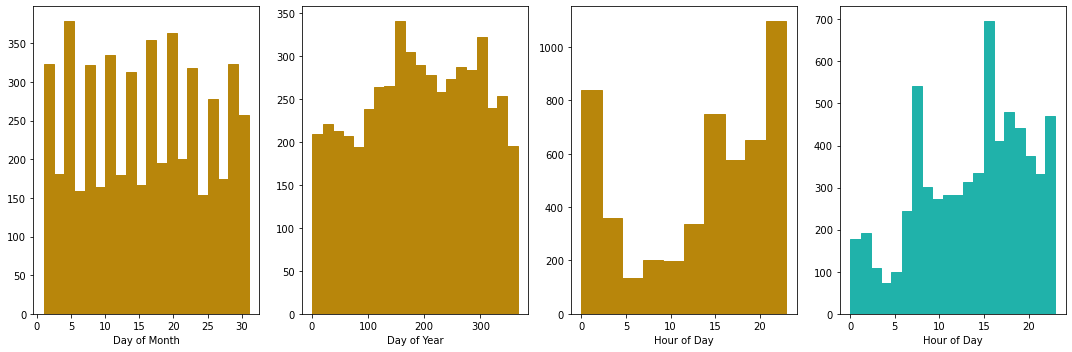

In [122]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
figure, ax = plt.subplots(1, 4, sharey=False, tight_layout=True, figsize=(15,5))

# We can set the number of bins with the `bins` kwarg
ax[0].hist(robbery_points_gdf_4326['dday'], bins=20, color = "darkgoldenrod", ec="darkgoldenrod")
ax[1].hist(robbery_points_gdf_4326['ddayofyear'], bins=20, color = "darkgoldenrod", ec="darkgoldenrod")
ax[2].hist(robbery_points_gdf_4326['dhour'], color = "darkgoldenrod", ec="darkgoldenrod")
ax[3].hist(pedestrian_points_gdf_4326['HOUR'], bins=20, color = "lightseagreen", ec="lightseagreen")

ax[0].set_xlabel('Day of Month')
ax[1].set_xlabel('Day of Year')
ax[2].set_xlabel('Hour of Day')
ax[3].set_xlabel('Hour of Day')

save_results_to = 'C:/Users/jodyn/PycharmProjects/InsightFDS/notebooks/figures/'
plt.savefig(save_results_to + 'Date-Histogram.png', dpi = 300)

C:\Users\jodyn\anaconda3\envs\OSMNX\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


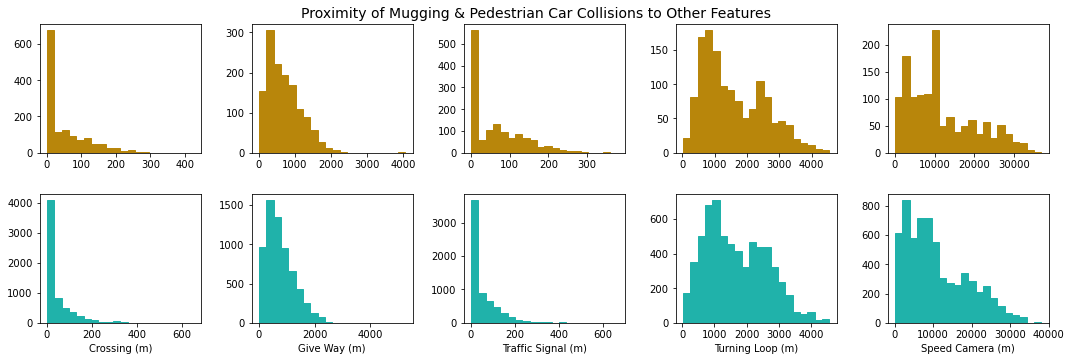

In [123]:
figure, ((axs1,axs2,axs3,axs4,axs5),(axs6,axs7,axs8,axs9,axs10)) = plt.subplots(2, 5, sharey=False, tight_layout=True,
                                                                                figsize=(15,5))

figure.tight_layout()
figure.tight_layout(pad=2.0)

figure.get_axes()[0].annotate('Proximity of Mugging & Pedestrian Car Collisions to Other Features', (0.5, 0.95), 
                            xycoords='figure fraction', ha='center', 
                            fontsize=14
                            )

# We can set the number of bins with the `bins` kwarg
axs1.hist(robbery_points_gdf_4326['crossing'], bins=20, color = "darkgoldenrod", ec="darkgoldenrod")
axs2.hist(robbery_points_gdf_4326['give_way'], bins=20, color = "darkgoldenrod", ec="darkgoldenrod")
axs3.hist(robbery_points_gdf_4326['traffic_signals'], bins=20, color = "darkgoldenrod", ec="darkgoldenrod")
axs4.hist(robbery_points_gdf_4326['turning_loop'], bins=20, color = "darkgoldenrod", ec="darkgoldenrod")
axs5.hist(robbery_points_gdf_4326['speed_camera'], bins=20, color = "darkgoldenrod", ec="darkgoldenrod")
axs6.hist(pedestrian_points_gdf_4326['crossing'], bins=20, color = "lightseagreen", ec="lightseagreen")
axs7.hist(pedestrian_points_gdf_4326['give_way'], bins=20, color = "lightseagreen", ec="lightseagreen")
axs8.hist(pedestrian_points_gdf_4326['traffic_signals'], bins=20, color = "lightseagreen", ec="lightseagreen")
axs9.hist(pedestrian_points_gdf_4326['turning_loop'], bins=20, color = "lightseagreen", ec="lightseagreen")
axs10.hist(pedestrian_points_gdf_4326['speed_camera'], bins=20, color = "lightseagreen", ec="lightseagreen")

axs6.set_xlabel('Crossing (m)')
axs7.set_xlabel('Give Way (m)')
axs8.set_xlabel('Traffic Signal (m)')
axs9.set_xlabel('Turning Loop (m)')
axs10.set_xlabel('Speed Camera (m)')

save_results_to = 'C:/Users/jodyn/PycharmProjects/InsightFDS/notebooks/figures/'
plt.savefig(save_results_to + 'Proximity-Histogram.png', dpi = 300)

Adding some psedo data based on the ranges of what are in the occurrences

In [33]:
special = list(set(list(robbery_points_gdf_4326)) - set(list(robbery_backgroundpoints_gdf_4326)))
for i in special:
    longer = list(robbery_points_gdf_4326[i].unique())
    call = numpy.repeat(longer,
                        len(robbery_backgroundpoints_gdf_4326) / len(longer) * 2)
    shuffle(call)
    robbery_backgroundpoints_gdf_4326[i] = call[0:len(robbery_backgroundpoints_gdf_4326)]

robbery_points_gdf_4326['Presence_Absence'] = numpy.repeat(1,
                                                           len(robbery_points_gdf_4326))
robbery_backgroundpoints_gdf_4326['Presence_Absence'] = numpy.repeat(0,
                                                                     len(robbery_backgroundpoints_gdf_4326))

special = list(set(list(pedestrian_points_gdf_4326)) - set(list(pedestrian_backgroundpoints_gdf_4326)))
for i in special:
    longer = list(pedestrian_points_gdf_4326[i].unique())
    call = numpy.repeat(longer,
                        len(pedestrian_backgroundpoints_gdf_4326) / len(longer) * 2)
    shuffle(call)
    pedestrian_backgroundpoints_gdf_4326[i] = call[0:len(pedestrian_backgroundpoints_gdf_4326)]

pedestrian_points_gdf_4326['Presence_Absence'] = numpy.repeat(1,
                                                           len(pedestrian_points_gdf_4326))
pedestrian_backgroundpoints_gdf_4326['Presence_Absence'] = numpy.repeat(0,
                                                                     len(pedestrian_backgroundpoints_gdf_4326))

In [57]:
# now we can combine both data sets and
robbery_model_data = robbery_points_gdf_4326.append(
    pandas.DataFrame(data=robbery_backgroundpoints_gdf_4326),
    ignore_index=True)
robbery_model_data_final = robbery_model_data.iloc[:, numpy.r_[0, 2:len(list(robbery_model_data))]]
robbery_model_data_final.Presence_Absence.value_counts()

0    20564
1     5141
Name: Presence_Absence, dtype: int64

In [46]:
pedestrian_model_data = pedestrian_points_gdf_4326.append(
    pandas.DataFrame(data=pedestrian_backgroundpoints_gdf_4326),
    ignore_index=True)
pedestrian_model_data_final = pedestrian_model_data.iloc[:, numpy.r_[0, 2:len(list(pedestrian_model_data))]]
pedestrian_model_data_final.Presence_Absence.value_counts()

0    25732
1     6433
Name: Presence_Absence, dtype: int64

In [47]:
print(pedestrian_model_data_final.isnull().sum())

YEAR                   0
HOUR                   0
ROAD_CLASS             0
Latitude               0
Longitude              0
VISIBILITY          2869
LIGHT                  0
geometry               0
crossing              51
give_way              51
stop                  51
traffic_signals       51
turning_loop          51
speed_camera          51
Presence_Absence       0
dtype: int64


In [27]:
list(pandas.get_dummies(pedestrian_model_data_final.iloc[:,numpy.r_[0:5,6,8:15]]))

['YEAR',
 'HOUR',
 'Latitude',
 'Longitude',
 'crossing',
 'give_way',
 'stop',
 'traffic_signals',
 'turning_loop',
 'speed_camera',
 'Presence_Absence',
 'ROAD_CLASS_Collector',
 'ROAD_CLASS_Expressway',
 'ROAD_CLASS_Local',
 'ROAD_CLASS_Major Arterial',
 'ROAD_CLASS_Minor Arterial',
 'LIGHT_Dark',
 'LIGHT_Dark, artificial',
 'LIGHT_Dawn',
 'LIGHT_Dawn, artificial',
 'LIGHT_Daylight',
 'LIGHT_Daylight, artificial',
 'LIGHT_Dusk',
 'LIGHT_Dusk, artificial',
 'LIGHT_Other']

In [58]:
print(robbery_model_data_final.isnull().sum())

Index_                 0
dyear                  0
dmonth                 0
dday                   0
ddayofyear             0
ddayofweek             0
dhour                  0
misetype               0
ffence                 0
Division               0
Hood_ID                0
Longitude              0
Latitude               0
geometry               0
crossing            3794
give_way            3794
stop                3794
traffic_signals     3794
turning_loop        3794
speed_camera        3794
Presence_Absence       0
dtype: int64


In [59]:
list(pandas.get_dummies(robbery_model_data_final.iloc[:,numpy.r_[1,3,4,6,9,10,11,12,20]]))

['dyear',
 'dday',
 'ddayofyear',
 'dhour',
 'Hood_ID',
 'Longitude',
 'Latitude',
 'Presence_Absence',
 'Division_D11',
 'Division_D12',
 'Division_D13',
 'Division_D14',
 'Division_D22',
 'Division_D23',
 'Division_D31',
 'Division_D32',
 'Division_D33',
 'Division_D41',
 'Division_D42',
 'Division_D43',
 'Division_D51',
 'Division_D52',
 'Division_D53',
 'Division_D54',
 'Division_D55']

**Pedestrian**: I will drop visibility, first, then I will make dummy variables.
**Robbery**: I wil drop the proximity features.

In [60]:
# need some dummy variables for my categorical data
# One-hot encode the data using pandas get_dummies
robbery_model_data_dummies = pandas.get_dummies(robbery_model_data_final.iloc[:,numpy.r_[1,3,4,6,9,10,11,12,20]])
pedestrian_model_data_dummies = pandas.get_dummies(pedestrian_model_data_final.iloc[:,numpy.r_[0:5,6,8:15]])
# NAs will give errors, so need to drop them
for i in list(robbery_model_data_dummies):
    robbery_model_data_dummies.dropna(subset=[i], inplace=True)
for i in list(pedestrian_model_data_dummies):
    pedestrian_model_data_dummies.dropna(subset=[i], inplace=True)

# do I need to balance data?
robbery_model_data_dummies.Presence_Absence.value_counts()

0    20564
1     5141
Name: Presence_Absence, dtype: int64

In [61]:
pedestrian_model_data_dummies.Presence_Absence.value_counts()

0    25732
1     6382
Name: Presence_Absence, dtype: int64

In [62]:
# combining the psedo absences and and occurences
pedestrian_model_data_dummies_p = pedestrian_model_data_dummies.loc[
    pedestrian_model_data_dummies["Presence_Absence"] == 1]
pedestrian_model_data_dummies_a = pedestrian_model_data_dummies.loc[
    pedestrian_model_data_dummies["Presence_Absence"] == 0]
pedestrian_model_data_dummies_a = pedestrian_model_data_dummies_a.sample(n=len(pedestrian_model_data_dummies_p))
pedestrian_model_data_dummies_bal = pedestrian_model_data_dummies_p.append(
    pandas.DataFrame(data=pedestrian_model_data_dummies_a),
    ignore_index=True)


robbery_model_data_dummies_p = robbery_model_data_dummies.loc[
    robbery_model_data_dummies["Presence_Absence"] == 1]
robbery_model_data_dummies_a = robbery_model_data_dummies.loc[
    robbery_model_data_dummies["Presence_Absence"] == 0]
robbery_model_data_dummies_a = robbery_model_data_dummies_a.sample(n=len(robbery_model_data_dummies_p))
robbery_model_data_dummies_bal = robbery_model_data_dummies_p.append(
    pandas.DataFrame(data=robbery_model_data_dummies_a),
    ignore_index=True)

In [63]:
robbery_model_data_dummies_bal.Presence_Absence.value_counts()

1    5141
0    5141
Name: Presence_Absence, dtype: int64

In [64]:
list(robbery_model_data_dummies_bal)

['dyear',
 'dday',
 'ddayofyear',
 'dhour',
 'Hood_ID',
 'Longitude',
 'Latitude',
 'Presence_Absence',
 'Division_D11',
 'Division_D12',
 'Division_D13',
 'Division_D14',
 'Division_D22',
 'Division_D23',
 'Division_D31',
 'Division_D32',
 'Division_D33',
 'Division_D41',
 'Division_D42',
 'Division_D43',
 'Division_D51',
 'Division_D52',
 'Division_D53',
 'Division_D54',
 'Division_D55']

In [65]:
pedestrian_model_data_dummies_bal.Presence_Absence.value_counts()

1    6382
0    6382
Name: Presence_Absence, dtype: int64

# Saving Data for Predicting Probabilties

In [66]:
import pickle
robbery_model_data_dummies_bal.to_pickle("C:/Users/jodyn/Google Drive/Insight/Processed Data/robbery_model_data_dummies_bal.pkl")
pedestrian_model_data_dummies_bal.to_pickle("C:/Users/jodyn/Google Drive/Insight/Processed Data/pedestrian_model_data_dummies_bal.pkl")